# Tree-based methods for regression
In the following section, we will consider the use of tree-based methods for regression. The materials that follows are analogous to that above, if not the similar.
## Preparation

In [1]:
library(tree)
library(randomForest)

data(imports85)
imp <- imports85

# The following data preprocessing steps on
# the imports85 dataset are suggested by
# the authors of the randomForest package
# look at
# > ?imports85
imp <- imp[,-2]  # Too many NAs in normalizedLosses.
imp <- imp[complete.cases(imp), ]
# ## Drop empty levels for factors
imp[] <- lapply(imp, function(x) if (is.factor(x)) x[, drop=TRUE] else x)

# Also removing the numOfCylinders and fuelSystem
# variables due to sparsity of data
# to see this, run the following lines:
# > table(imp$numOfCylinders)
# > table(imp$fuelSystem)
# This additional step is only necessary because we will be
# making comparisons between the tree-based models
# and linear regression, and linear regression cannot
# handle sparse data well
imp <- subset(imp, select = -c(numOfCylinders,fuelSystem))

# Preparation for cross validation:
# split the dataset into 2 halves,
# 96 samples for training and 97 for testing
num.samples <- nrow(imp) # 193
num.train   <- round(num.samples / 2) # 96
num.test    <- num.samples - num.train # 97
num.var     <- ncol(imp) # 25

# set up the indices
set.seed(150715)
idx       <- sample(1:num.samples)
train.idx <- idx[seq(num.train)]
test.idx  <- setdiff(idx,train.idx)

# subset the data
imp.train <- imp[train.idx,]
imp.test  <- imp[test.idx,]

str(imp.train)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


'data.frame':	96 obs. of  23 variables:
 $ symboling       : int  1 0 0 3 2 1 1 1 3 2 ...
 $ make            : Factor w/ 21 levels "alfa-romero",..: 12 13 14 19 20 19 13 9 12 17 ...
 $ fuelType        : Factor w/ 2 levels "diesel","gas": 2 2 2 2 1 2 2 2 2 2 ...
 $ aspiration      : Factor w/ 2 levels "std","turbo": 2 1 2 1 1 1 1 1 2 2 ...
 $ numOfDoors      : Factor w/ 2 levels "four","two": 1 1 1 2 2 2 1 2 2 1 ...
 $ bodyStyle       : Factor w/ 5 levels "convertible",..: 4 4 4 3 4 4 4 3 3 4 ...
 $ driveWheels     : Factor w/ 3 levels "4wd","fwd","rwd": 2 2 3 3 2 3 2 2 2 2 ...
 $ engineLocation  : Factor w/ 2 levels "front","rear": 1 1 1 1 1 1 1 1 1 1 ...
 $ wheelBase       : num  96.3 97.2 108 102.9 97.3 ...
 $ length          : num  172 173 187 184 172 ...
 $ width           : num  65.4 65.2 68.3 67.7 65.5 64 63.8 66.5 65.4 66.5 ...
 $ height          : num  51.6 54.7 56 52 55.7 52.6 54.5 53.7 49.4 56.1 ...
 $ curbWeight      : int  2403 2302 3130 2976 2261 2265 1971 2385 2370 2847 .

In [2]:
str(imp.test)

'data.frame':	97 obs. of  23 variables:
 $ symboling       : int  -1 1 -1 1 1 -2 0 0 2 2 ...
 $ make            : Factor w/ 21 levels "alfa-romero",..: 10 3 10 19 13 21 10 8 19 12 ...
 $ fuelType        : Factor w/ 2 levels "diesel","gas": 2 2 1 2 2 2 1 2 2 2 ...
 $ aspiration      : Factor w/ 2 levels "std","turbo": 1 1 2 1 1 1 2 1 1 1 ...
 $ numOfDoors      : Factor w/ 2 levels "four","two": 1 1 1 2 2 1 2 2 2 2 ...
 $ bodyStyle       : Factor w/ 5 levels "convertible",..: 4 4 5 4 4 4 2 4 1 3 ...
 $ driveWheels     : Factor w/ 3 levels "4wd","fwd","rwd": 3 3 3 3 2 3 3 3 3 2 ...
 $ engineLocation  : Factor w/ 2 levels "front","rear": 1 1 1 1 1 1 1 1 1 1 ...
 $ wheelBase       : num  115.6 103.5 110 94.5 94.5 ...
 $ length          : num  203 189 191 169 165 ...
 $ width           : num  71.7 66.9 70.3 64 63.8 67.2 70.3 70.6 65.6 64.4 ...
 $ height          : num  56.5 55.7 58.7 52.6 54.5 56.2 54.9 47.8 53 50.8 ...
 $ curbWeight      : int  3740 3055 3750 2169 1918 2935 3495 3950 2975 1

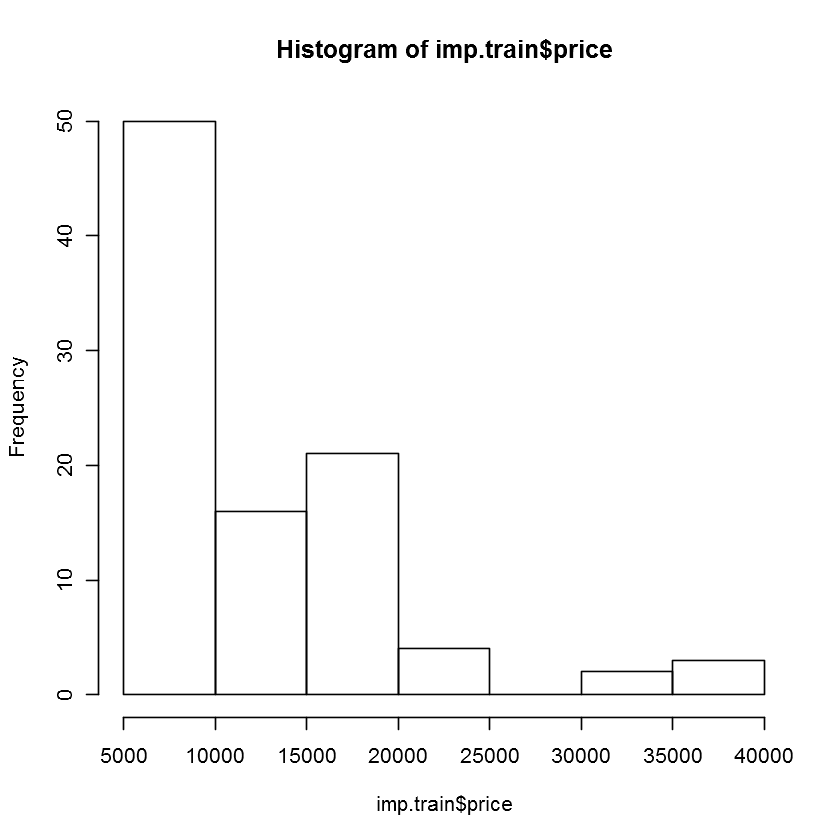

In [4]:
# take a quick look
hist(imp.train$price)

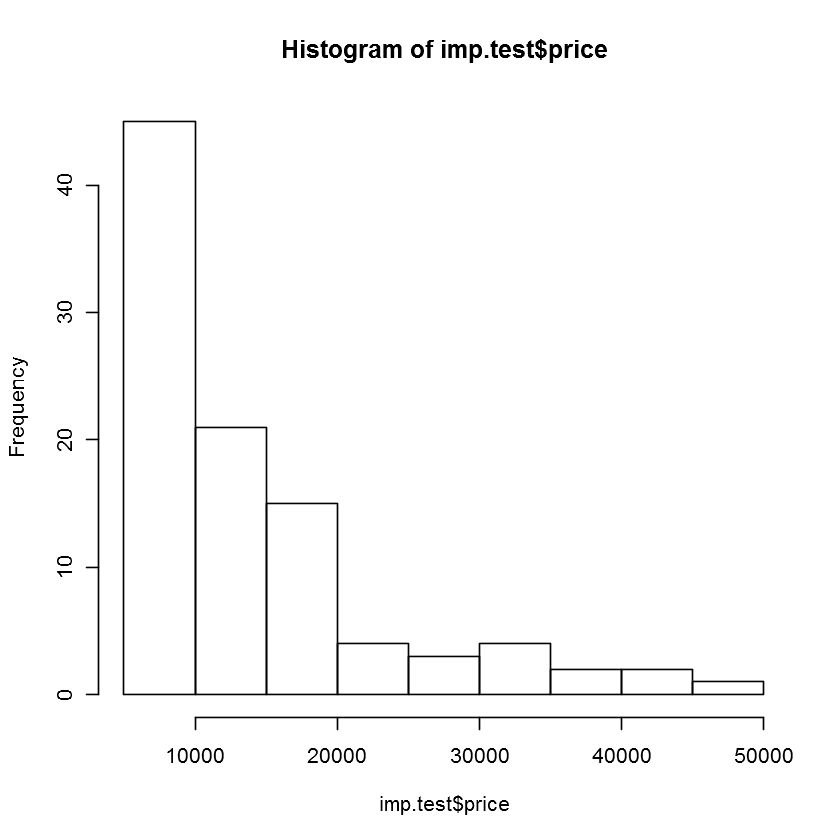

In [5]:
hist(imp.test$price)

We will be predicting the price of imported automobiles in this example. While tree-based methods are scale-invariant with respect to predictor variables, this is not true for the response variable. Hence, let’s take a log-transformation on price here.

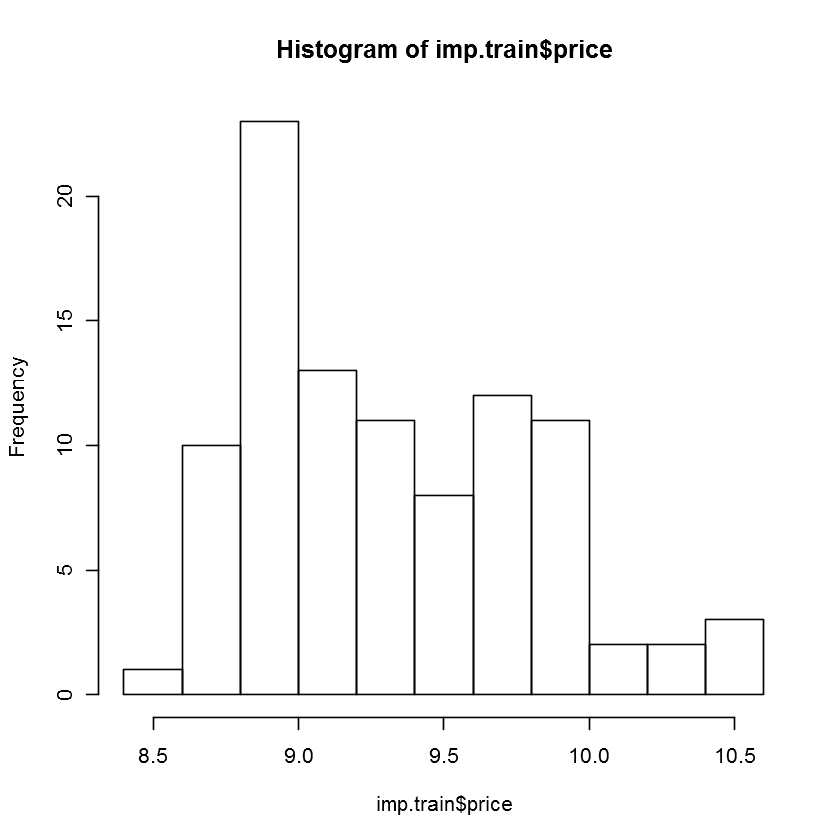

In [6]:
imp.train$price <- log(imp.train$price)
imp.test$price <- log(imp.test$price)

# take a look again
hist(imp.train$price)

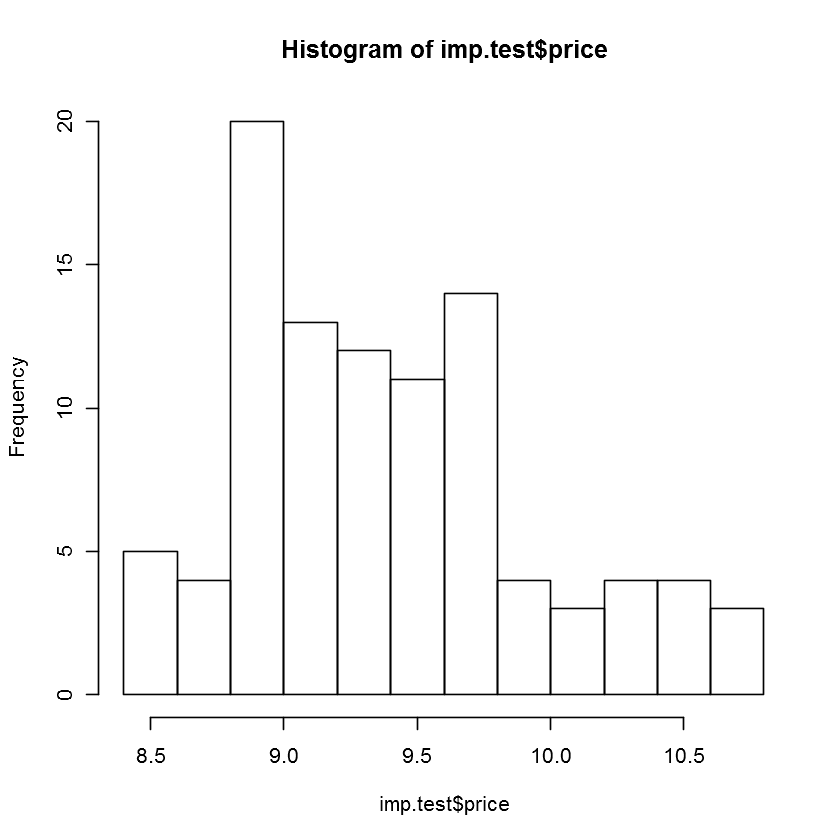

In [7]:
hist(imp.test$price)

## Decision tree
Done with the preparation, let’s begin with decision trees.

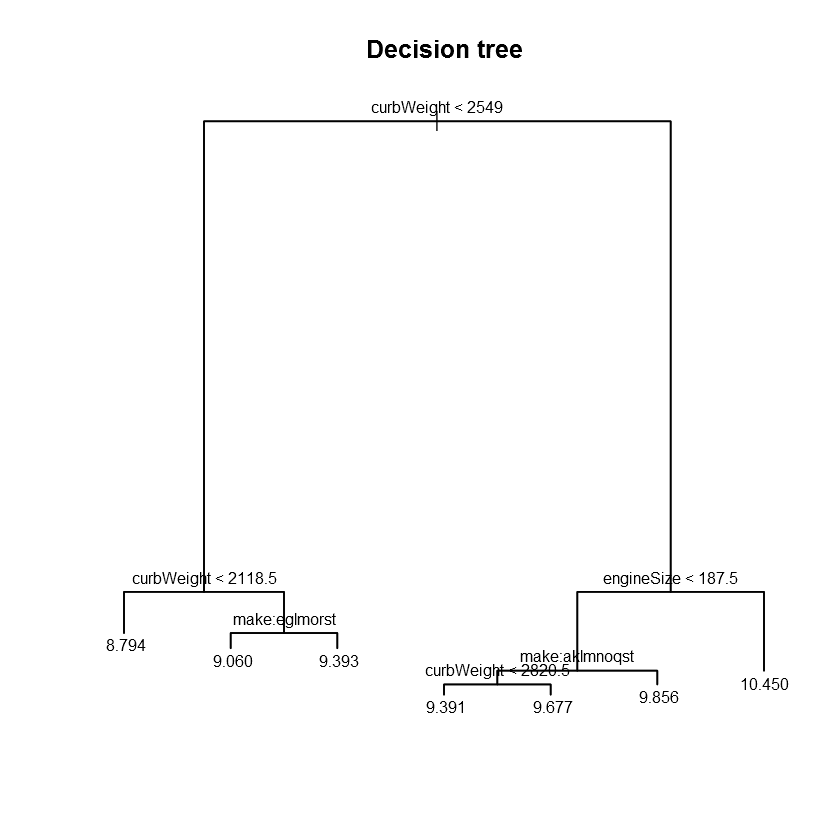

In [8]:
# Construct decision tree model
tree.mod <- tree(price ~ ., data = imp.train)

# here's how the model looks like
plot(tree.mod)
title("Decision tree")
text(tree.mod, cex = 0.75)

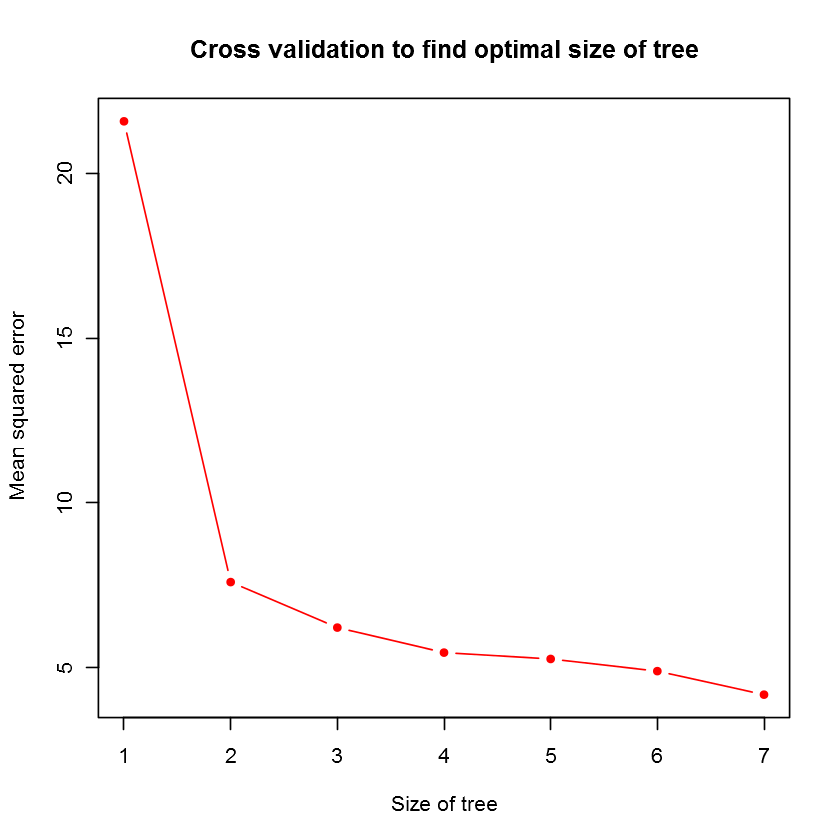

In [9]:
# let's see if our decision tree requires pruning
cv.prune <- cv.tree(tree.mod, FUN = prune.tree)
plot(cv.prune$size, cv.prune$dev, pch = 20, col = "red", type = "b",
     main = "Cross validation to find optimal size of tree",
     xlab = "Size of tree", ylab = "Mean squared error")

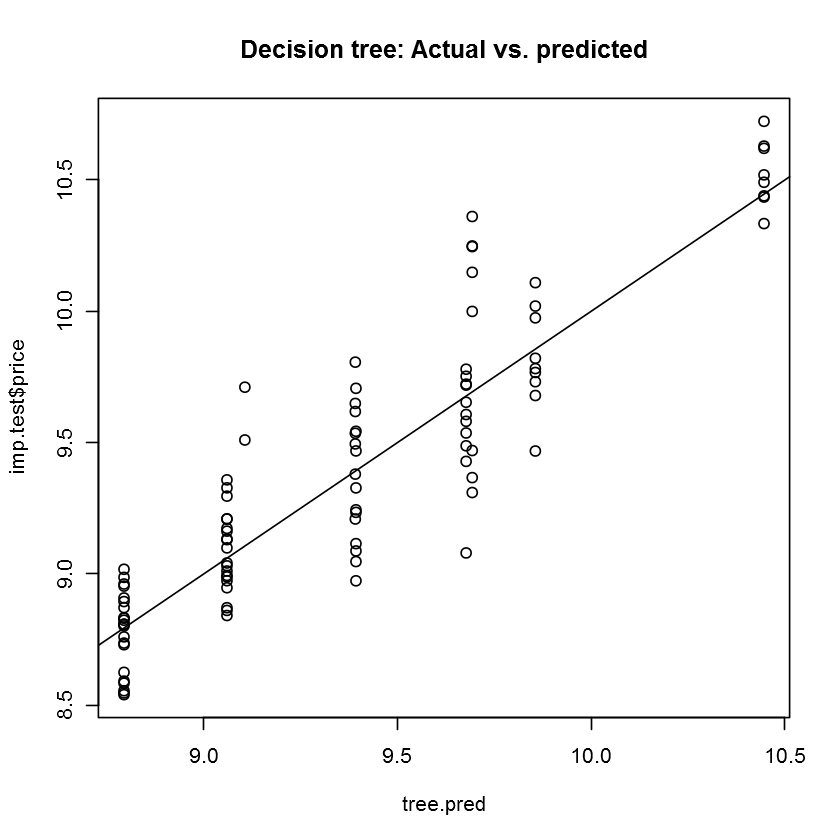

In [10]:
# looks fine

# now let's make some predictions
tree.pred <- predict(tree.mod,
                     subset(imp.test,select = -price), 
                     type = "vector")

# Comparing our predictions with the test data:
plot(tree.pred, imp.test$price, main = "Decision tree: Actual vs. predicted")
abline(a = 0, b = 1) # A prediction with zero error will lie on the y = x line

In [11]:
# What is the MSE of our model?
print(tree.mse <- mean((tree.pred - imp.test$price) ** 2))

[1] 0.05269093


Our decision tree model predicts the price of imported automobiles with a mean squared error of 0.0527. As with the previous section, we will make comparsions on model performances later.

## Bagging
Next, bagging.

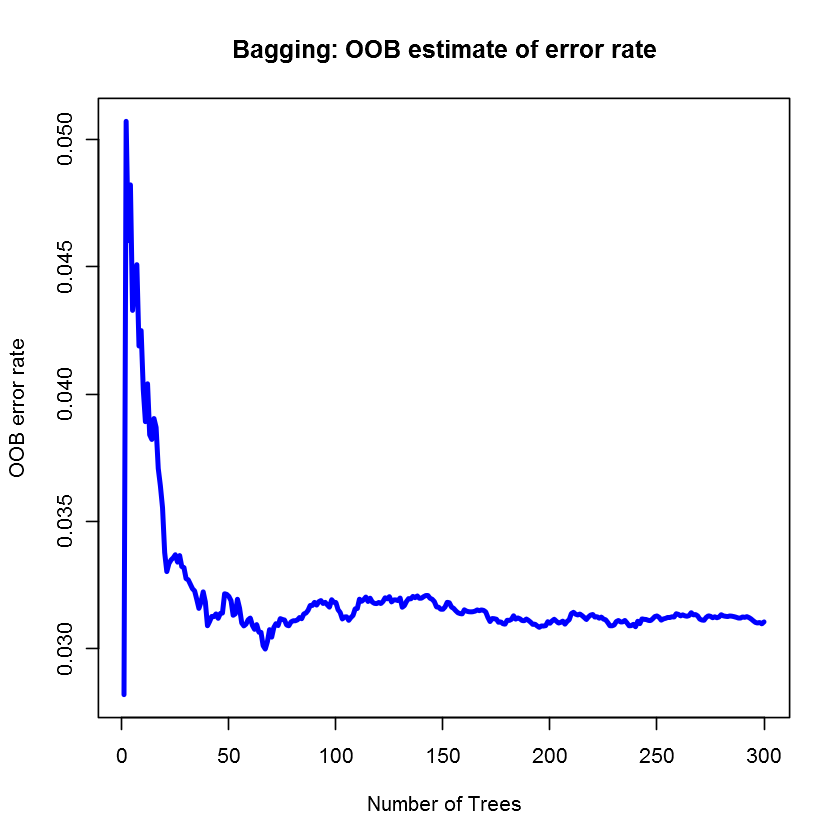

In [12]:
bg.mod<-randomForest(price ~ ., data = imp.train,
                     mtry = num.var - 1, # try all variables at each split, except the response variable
                     ntree = 300,
                     importance = TRUE)

# Out-of-bag (OOB) error rate as a function of num. of trees
# here, the error is the mean squared error,
# not classification error
plot(bg.mod$mse, type = "l", lwd = 3, col = "blue",
     main = "Bagging: OOB estimate of error rate",
     xlab = "Number of Trees", ylab = "OOB error rate")

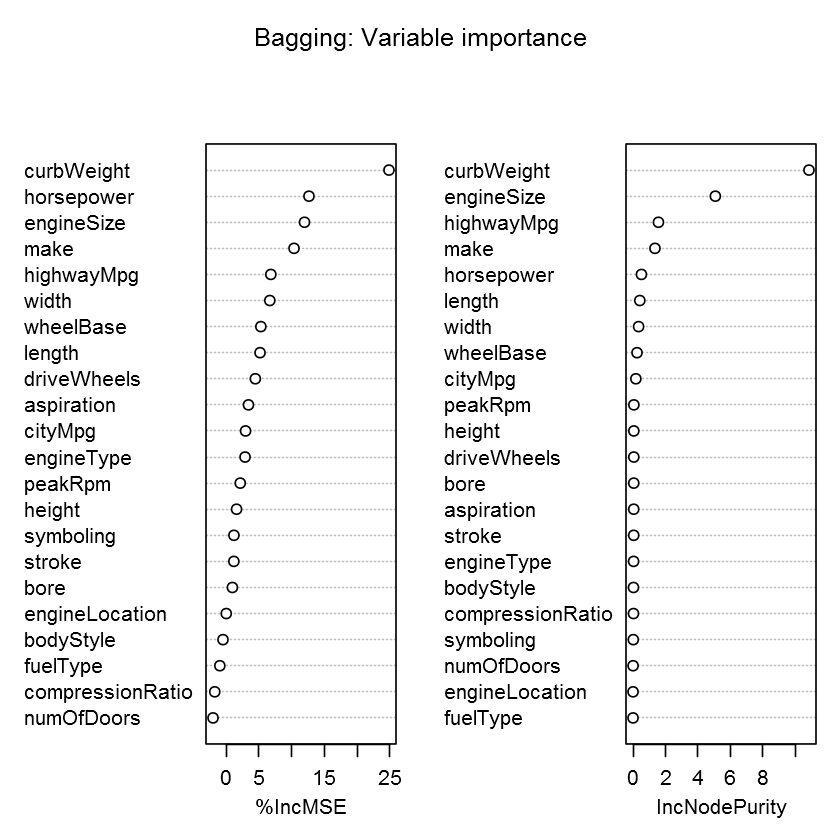

In [13]:
# variable importance
varImpPlot(bg.mod,
           main = "Bagging: Variable importance")

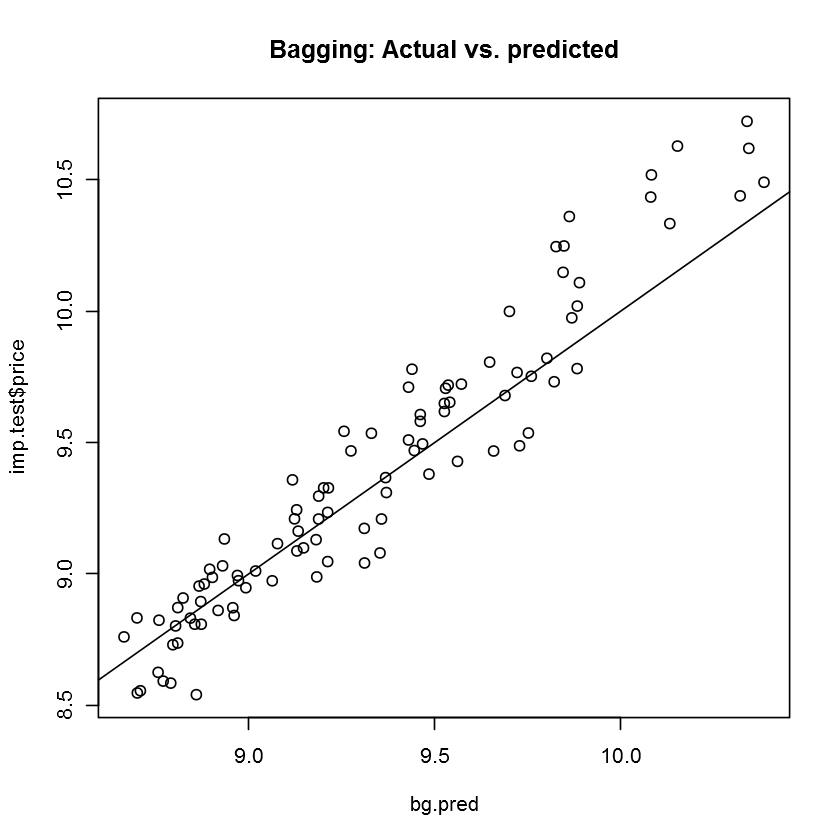

In [14]:
# let's make some predictions
bg.pred <- predict(bg.mod,
                   subset(imp.test,select = -price))

# Comparing our predictions with test data:
plot(bg.pred,imp.test$price, main = "Bagging: Actual vs. predicted")
abline(a = 0, b = 1)

In [15]:
# MSE of bagged model
print(bg.mse <- mean((bg.pred - imp.test$price) ** 2))

[1] 0.03320479


Our bagging model predicts the price of imported automobiles with a mean squared error of 0.0334.

## Random forest
Finally, the random forest model.

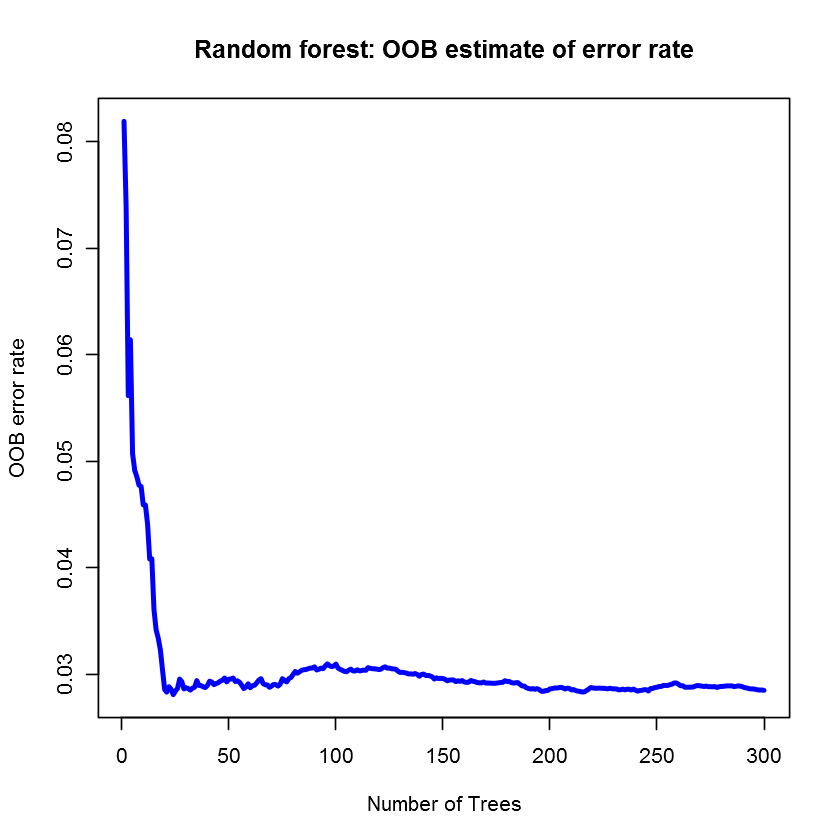

In [16]:
rf.mod<-randomForest(price ~ ., data = imp.train,
                     mtry = floor((num.var - 1) / 3), # 7; only difference from bagging is here
                     ntree = 300,
                     importance = TRUE)

# Out-of-bag (OOB) error rate as a function of num. of trees
plot(rf.mod$mse, type = "l", lwd = 3, col = "blue",
     main = "Random forest: OOB estimate of error rate",
     xlab = "Number of Trees", ylab = "OOB error rate")

mtry = 7  OOB error = 0.02805746 
Searching left ...
mtry = 4 	OOB error = 0.03351286 
-0.1944364 0.05 
Searching right ...
mtry = 14 	OOB error = 0.03113901 
-0.1098298 0.05 


,mtry,OOBError
4,4.00000000,0.03351286
7,7.00000000,0.02805746
14,14.00000000,0.03113901


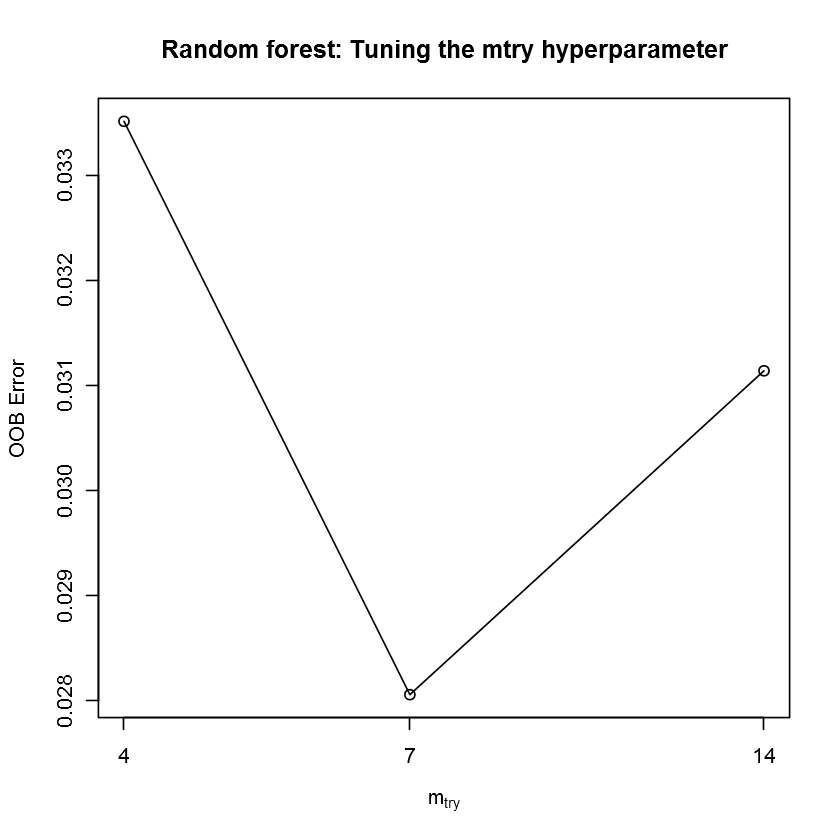

In [17]:
# tuning the mtry hyperparameter:
# model may be rebuilt if desired
tuneRF(subset(imp.train, select = -price),
       imp.train$price,
       ntreetry = 100)

title("Random forest: Tuning the mtry hyperparameter")

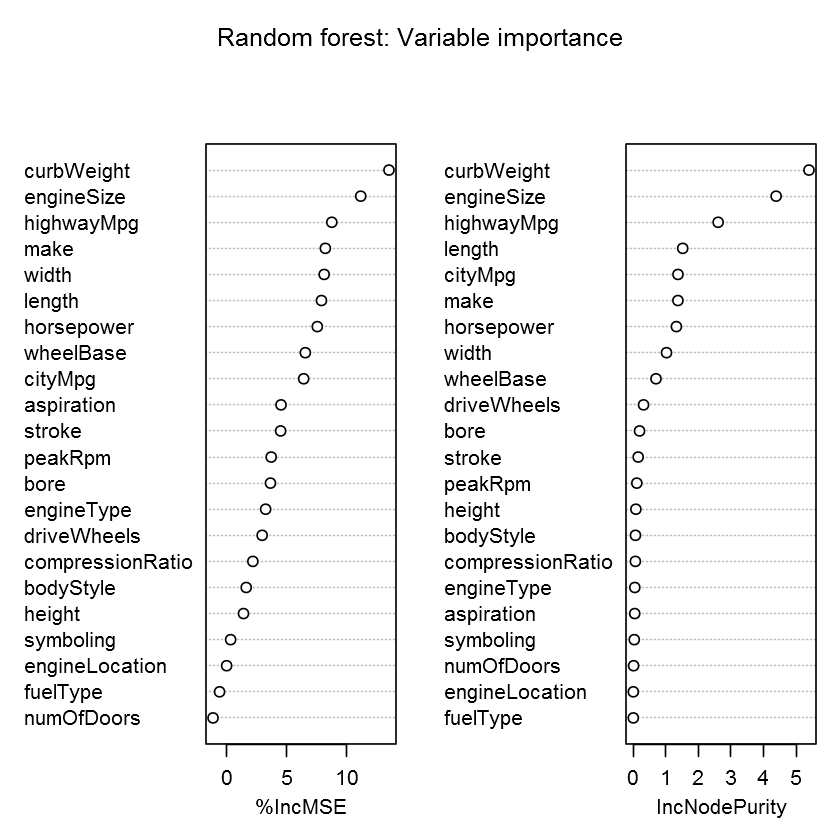

In [18]:
# variable importance
varImpPlot(rf.mod,
           main = "Random forest: Variable importance")

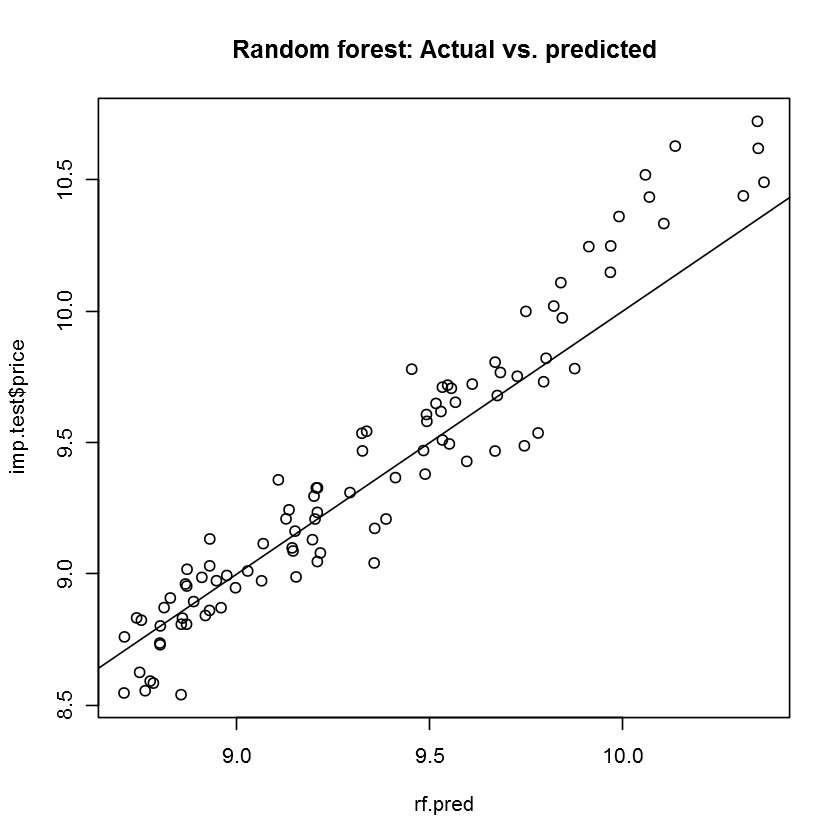

In [19]:
# let's make some predictions
rf.pred <- predict(rf.mod,
                   subset(imp.test, select = -price))

# Comparing our predictions with test data:
plot(rf.pred, imp.test$price, main = "Random forest: Actual vs. predicted")
abline(a = 0, b = 1)

In [20]:
# MSE of RF model
print(rf.mse <- mean((rf.pred - imp.test$price) ** 2))

[1] 0.0293162


Our random forest model incurs a mean squared error of 0.0291 for the prediction of imported automobile prices

## Visualization of performances
For comparison purposes, let’s also construct a ordinary least squares (linear regression) model.

In [22]:
ols.mod <- lm(price ~ ., data = imp.train)

# predictions
ols.pred <- predict(ols.mod,
                   subset(imp.test, select = -price))

Warning message:
In predict.lm(ols.mod, subset(imp.test, select = -price)): prediction from a rank-deficient fit may be misleading

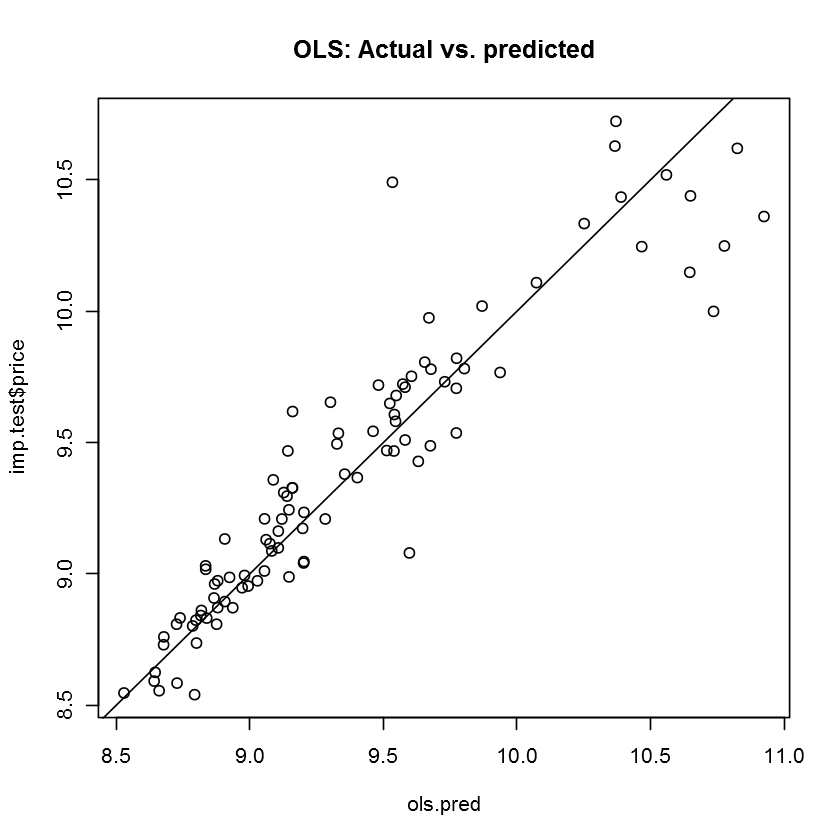

In [23]:
# comparisons with test data:
plot(ols.pred, imp.test$price, main = "OLS: Actual vs. predicted")
abline(a = 0, b = 1)

In [24]:
# MSE
print(ols.mse <- mean((ols.pred-imp.test$price) ** 2))

[1] 0.04669281


Now, let’s compare their performances.

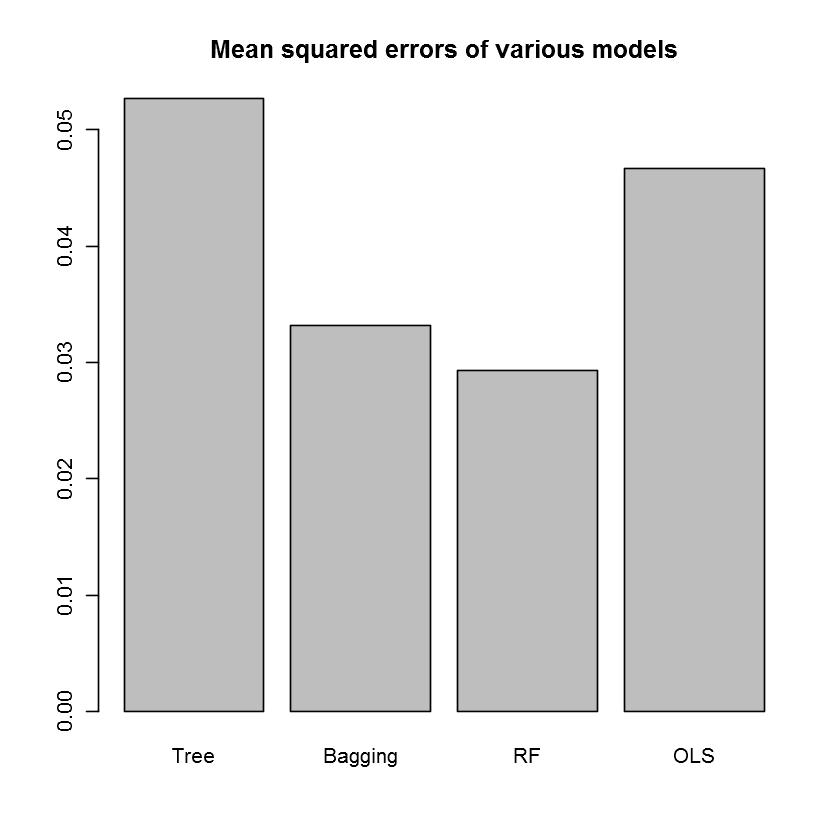

In [25]:
# Comparing MSEs of various models:
barplot(c(tree.mse,
          bg.mse,
          rf.mse,
          ols.mse),
        main = "Mean squared errors of various models",
        names.arg = c("Tree", "Bagging", "RF", "OLS"))

Our top performer here is the random forest model, followed by the bagging model.

END